In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [180]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer

In [181]:
df = pd.read_csv("train.csv")

In [182]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
844,845,0,3,"Culumovic, Mr. Jeso",male,17.0,0,0,315090,8.6625,NaN,S
196,197,0,3,"Mernagh, Mr. Robert",male,NaN,0,0,368703,7.7500,NaN,Q
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0000,B28,NaN
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C
92,93,0,1,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,W.E.P. 5734,61.1750,E31,S


In [183]:
df.drop(columns = ["PassengerId","Name","Ticket","Cabin"],inplace=True)

In [184]:
x_train,x_test,y_train,y_test = train_test_split(df.drop(columns=["Survived"]),
                                                 df["Survived"],test_size=0.2,random_state=42)

In [185]:
x_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,1,male,45.5,0,0,28.5000,S
733,2,male,23.0,0,0,13.0000,S
382,3,male,32.0,0,0,7.9250,S
704,3,male,26.0,1,0,7.8542,S
813,3,female,6.0,4,2,31.2750,S


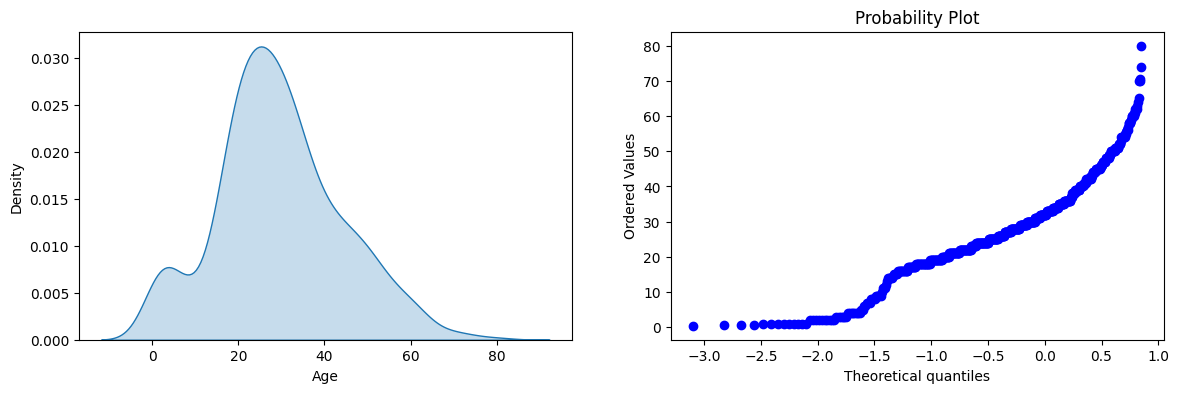

In [186]:
plt.figure(figsize = (14,4))
plt.subplot(121)
sns.kdeplot(data = x_train,x = "Age",fill = True)
plt.subplot(122)
stats.probplot(x_train["Age"],dist = "norm",plot = plt)
plt.show()

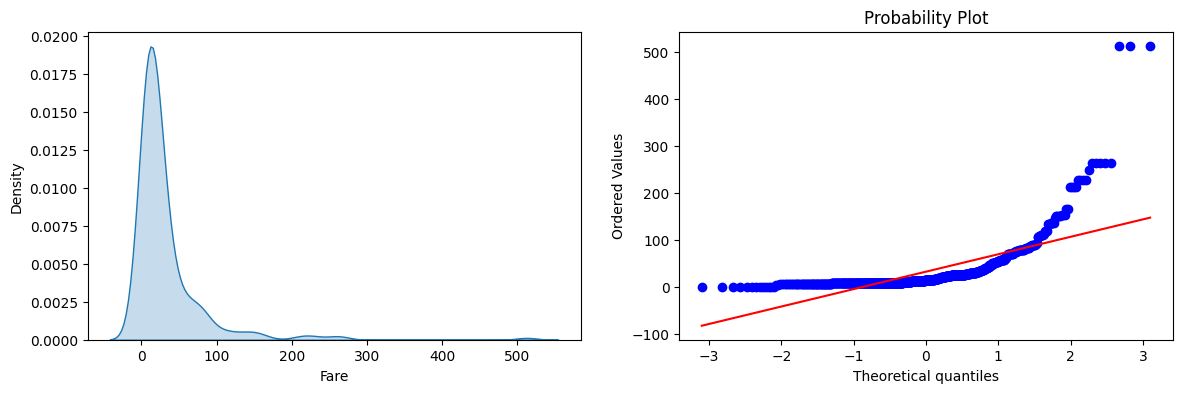

In [187]:
plt.figure(figsize = (14,4))
plt.subplot(121)
sns.kdeplot(data = x_train,x = "Fare",fill = True)
plt.subplot(122)
stats.probplot(x_train["Fare"],dist = "norm",plot = plt)
plt.show()

In [188]:
# imputating transformer
trf1 = ColumnTransformer([
    ('impute_age',SimpleImputer(),[2]),
    ('impute_embarked',SimpleImputer(strategy="most_frequent"),[6])
],remainder='passthrough')

In [189]:
# one hot encoding
trf2 = ColumnTransformer([
    ('ohe_sex_embarked',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),[1,6])
],remainder='passthrough')

In [190]:
# scaling
trf3 = ColumnTransformer([
    ('scale',MinMaxScaler(),slice(0,10))
])

In [191]:
trf = ColumnTransformer([("log",FunctionTransformer(np.log1p),[2,5])],remainder='passthrough')

# x_train = trf.fit_transform(x_train)
# x_test = trf.transform(x_test)

In [192]:
# feature selection
trf4 = SelectKBest(score_func=chi2,k=8)

In [193]:
# train the model
trf5 = RandomForestRegressor(n_estimators=100,random_state=42)


Create pipeline

In [194]:
pipe = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2),
    ('trf3',trf3),
    ('trf',trf),
    ('trf4',trf4),
    ('trf5',trf5)
])

In [195]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_age', SimpleImputer(),
                                                  [2]),
                                                 ('impute_embarked',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [6])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_sex_embarked',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [1, 6])])),
                ('trf3',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  slice(0, 10, None))])),
                ('trf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  [2, 5])])),
                ('trf4',
                 SelectKBest(k=8,
                             score_func=<function chi2 at 0x7926d0812e80>)),
                ('trf5', RandomForestRegressor(random_state=42))])

In [196]:
pipe.named_steps

{'trf1': ColumnTransformer(remainder='passthrough',
                   transformers=[('impute_age', SimpleImputer(), [2]),
                                 ('impute_embarked',
                                  SimpleImputer(strategy='most_frequent'),
                                  [6])]),
 'trf2': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe_sex_embarked',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                                  [1, 6])]),
 'trf3': ColumnTransformer(transformers=[('scale', MinMaxScaler(), slice(0, 10, None))]),
 'trf': ColumnTransformer(remainder='passthrough',
                   transformers=[('log',
                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                  [2, 5])]),
 'trf4': SelectKBest(k=8, score_func=<function chi2 at 0x7926d0812e80>),
 'trf5': RandomForestRegressor(rando

In [197]:
ypred = pipe.predict(x_test)

In [198]:
from sklearn.metrics import accuracy_score

# Convert continuous predictions to binary predictions
ypred_binary = (ypred > 0.5).astype(int)

accuracy_score(y_test,ypred_binary)

0.6256983240223464